In [1]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Use a pipeline as a high-level helper
#from transformers import pipeline

#pipe = pipeline("object-detection", model="microsoft/table-transformer-structure-recognition")

In [2]:
# Load model directly
#from transformers import AutoFeatureExtractor, AutoModelForObjectDetection

#extractor = AutoFeatureExtractor.from_pretrained("microsoft/table-transformer-structure-recognition")
#model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [3]:
#from ultralyticsplus import YOLO, render_result

# load model
#model = YOLO('foduucom/table-detection-and-extraction')

# set model parameters
#model.overrides['conf'] = 0.25  # NMS confidence threshold
#model.overrides['iou'] = 0.45  # NMS IoU threshold
#model.overrides['agnostic_nms'] = False  # NMS class-agnostic
#model.overrides['max_det'] = 1000  # maximum number of detections per image

# set image
#image = 'pgcImage.png'

# perform inference
#results = model.predict(image)

# observe results
#print(results[0].boxes)
#render = render_result(model=model, image=image, result=results[0])
#render.show()

In [4]:
from transformers import AutoImageProcessor, TableTransformerModel
from huggingface_hub import hf_hub_download
from PIL import Image
import numpy as np

#file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open("pgcImage.png").convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerModel.from_pretrained("microsoft/table-transformer-detection")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# the last hidden states are the final query embeddings of the Transformer decoder
# these are of shape (batch_size, num_queries, hidden_size)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


[1, 15, 256]

In [5]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageEnhance

#file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
#image = Image.open(file_path).convert("RGB")
def EnhanceImage(image, rate):
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(rate)

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(rate)

    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(rate)

    image.save('imageEnhanced.png')
    return image
    
def tableDetector(image):
    image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
    model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
    labelList = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        labelList.append(model.config.id2label[label.item()])
        #print(
            #f"Detected {model.config.id2label[label.item()]} with confidence "
            #f"{round(score.item(), 3)} at location {box}"
        #)
    return results["scores"].tolist(), labelList, results["boxes"].tolist()
#tableDetector(image)

In [6]:
def orderTable(label_results, box_results):
    linhas = []
    colunas = []
    for score, label, box in zip(score_results, label_results, box_results):
        if label == "table row":
            linhas.append([box[0], box[1], box[2], box[3]])
        elif label == "table column":
            colunas.append([box[0], box[1], box[2], box[3]])
    colunas.sort(key =lambda x: x[0])
    linhas.sort(key=lambda x: x[1])
    return linhas, colunas

def colorTable(linhas, colunas, image):
    plt.imshow(image)
    ax = plt.gca()
    blue = 0
    for row in linhas:
        green= 0
        red = 1
        blue =blue + 0.06
        for column in colunas:
            red = red - 0.1
            green= green +0.1
            ax.add_patch(plt.Rectangle((column[0], row[1]), column[2] - column[0], row[3] - row[1],fill=False, color=(red, green, blue), linewidth=1))
    plt.show()
    #plt.rcParams["figure.figsize"] = (30,25)
    #plt.savefig("ImagemProcessada.png")

In [7]:
#import pytesseract
#palavras = []
#custon_config = r'--oem 3 --psm 6'
#for row in linhas:
#    for column in colunas:
#        cut = image.crop((column[0], row[1], column[2], row[3]))
#        palavras.append(pytesseract.image_to_string(cut, config=custon_config,lang='eng'))
#print(palavras)

In [8]:
#cut = image.crop((colunas[0][0], linhas[0][1], colunas[0][2], linhas[0][3]))
#pytesseract.image_to_string(cut)
#cut

In [9]:
import cv2
imageTabela = cv2.imread('pgcImage.png')
imageTabelaCortada = cv2.imread('pgcImagecut2.png')

#result = reader.readtext(easyImage)

In [10]:
import easyocr
def detecta_palavras(linhas, colunas, im):
    resultados = []
    reader = easyocr.Reader(['pt'])
    for row in linhas:
        for column in colunas:
            #print(int(row[1]), int(row[3]), int(column[0]), int(column[2]))
            #cv2.imshow("cropped",easyImage[int(column[0]): int(column[2]), int(row[1]): int(row[3])])
            cut = im.crop((int(column[0]), int(row[1]), int(column[2]), int(row[3])))
            resultados.append(lerTexto(cut))
    return resultados

In [11]:
from PIL import Image, ImageEnhance
def compara_resultados(im, threshold, linhas, colunas, titulo_image):

    palavras_im_normal = detecta_palavras(linhas,  colunas, im)
    
    #th, im_binarizada = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY)
    #palavras_im_binarizada = detecta_palavras(linhas, colunas, im_binarizada)

    #th, im_THRESH_TOZERO = cv2.threshold(im, threshold, 255, cv2.THRESH_TOZERO)
    #palavras_im_THRESH_TOZERO = detecta_palavras(linhas, colunas, im_THRESH_TOZERO)

    #im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    #th, im_THRESH_OTSU = cv2.threshold(im_gray, threshold, 192, cv2.THRESH_OTSU)
    #palavras_im_THRESH_OTSU = detecta_palavras(linhas, colunas, im_THRESH_OTSU)

    #th, im_THRESH_TRIANGLE = cv2.threshold(im_gray, threshold, 192, cv2.THRESH_TRIANGLE)
    #palavras_im_THRESH_TRIANGLE = detecta_palavras(linhas, colunas, im_THRESH_TRIANGLE)
    
    print(titulo_image +" \n Sem binarização:")
    print(palavras_im_normal)
    #print("\n BINARIZADA")
    #print(palavras_im_binarizada)
    # print("\n THRESH_TOZERO:")
    # print(palavras_im_THRESH_TOZERO)
    # print("\n THRESH_OTSU:")
    #print(palavras_im_THRESH_OTSU)
    # print("\n THRESH_TRIANGLE:")
    #print(palavras_im_THRESH_TRIANGLE)
#palavras

In [40]:
from skimage.filters import threshold_otsu
import numpy as np
from skimage.color import rgb2gray
import pytesseract
basewidth = 500
#img = Image.open("pgcSample2.jpg")
#wpercent = (basewidth/float(img.size[0]))
#hsize = int((float(img.size[1])*float(wpercent)))
#img = img.resize((basewidth,hsize), Image.LANCZOS)
#img.save("pgcImagemAumentada.jpg")
#img = cv2.imread("pgcImagemAumentada.jpg")

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(imggray):
    threshold = threshold_otsu(imggray)
    return imggray < threshold
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

def lerTexto (img):
    img.save("pgcImageLerTexto.jpg")
    img = cv2.imread("pgcImageLerTexto.jpg")
    if img.ndim > 2: # is this is a rgb/rgba image
        imggray = rgb2gray(img)
    binarized_image = binarize_image(imggray)
    hpp = horizontal_projections(binarized_image)
    
    # find the threshold from where anything above is considered a peak region
    # using the average for now but this needs further research. This may or may not work on all images.
    #threshold = (np.max(hpp)-np.min(hpp))/2
    threshold = 6
    peaks = find_peak_regions(hpp, threshold)
    peaks_indexes = np.array(peaks)[:, 0].astype(int)
    segmented_img = np.copy(imggray)
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0
    # group the peaks through which we will be doing path planning.
    diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
    indexes_with_larger_diff = np.where(diff_between_consec_numbers >1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)[1:]
    # remove very small regions, these are basically errors in algorithm because of our threshold value
    peak_groups = [item for item in peak_groups if len(item) > 4]
    
    resultados = []
    reader = easyocr.Reader(['pt'])
    imgResize = Image.fromarray(img, "RGB")
    wpercent = (basewidth/float(imgResize.size[0]))
    hsize = int((float(imgResize.size[1])*float(wpercent)))
    imgResize = imgResize.resize((basewidth,hsize), Image.LANCZOS)
    resultados.append(pytesseract.image_to_string(imgResize))
    # for index, sub_image_index in enumerate(peak_groups):
    #     sub_image = img[sub_image_index[0]:sub_image_index[1]]
    #     imgResize = Image.fromarray(sub_image, "RGB")
    #     wpercent = (basewidth/float(imgResize.size[0]))
    #     hsize = int((float(imgResize.size[1])*float(wpercent)))
    #     imgResize = imgResize.resize((basewidth,hsize), Image.LANCZOS)
    #     resultados.append(pytesseract.image_to_string(imgResize))
    return resultados

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeq

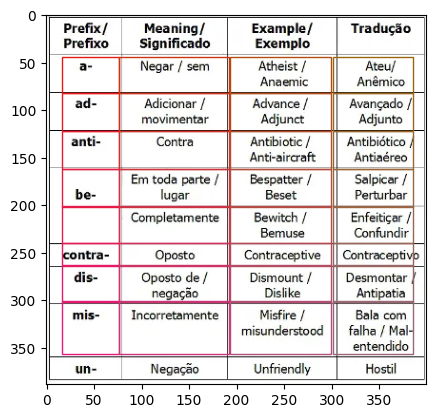

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster wi

Imagem Inteira 
 Sem binarização:
[['\x0c'], ['Negar / sem\n\x0c'], ['Atheist /\nAnaemic\n\x0c'], ['Ateu/\nAnémico\n\x0c'], ['ad-\n\x0c'], ['Adicionar /\nmovimentar\n\x0c'], ['Advance /\nAdjunct\n\x0c'], ['Avancado /\nAdjunto\n\x0c'], ['anti-\n\x0c'], ['Contra |\n\x0c'], ['Antibiotic /\nAnti-aircraft\n\n \n\x0c'], [' \n\nAntibiotico ;\nAntiaéreo\n\x0c'], ['be-\n\x0c'], ['Em toda parte /\nlugar\n\x0c'], ['Bespatter /\nBeset\n\x0c'], ['Salpicar /\nPerturbar\n\x0c'], ['\x0c'], ['Completamente\n\x0c'], ['Bewitch /\nBemuse\n\x0c'], ['Enfeiticar /\nConfundir\n\x0c'], ['contra-\n\x0c'], ['Oposto |\n\x0c'], ['Contraceptive\n\x0c'], ['| Contraceptiv\n\x0c'], ['dis-\n\x0c'], ['Oposto de /\nnegacao |\n\x0c'], ['Dismount /\nDislike\n\x0c'], ['Desmontar ,\nAntipatia\n\x0c'], ['\x0c'], ['Incorretamente\n\x0c'], ['Misfire /\nmisunderstood\n\x0c'], ['Bala com\nfalha / Mal-\nentendido\n\x0c']]

 THRESH_TOZERO:

 THRESH_OTSU:

 THRESH_TRIANGLE:


In [43]:
image = Image.open("pgcIngles.png").convert("RGB")
#image = EnhanceImage(image, 1.3)
score_results, label_results, box_results = tableDetector(image)
linhas, colunas = orderTable(label_results, box_results)
colorTable(linhas, colunas, image)
compara_resultados(image, 128, linhas, colunas, "Imagem Inteira")

In [ ]:
image = Image.open("pgcImagecut2.png").convert("RGB")
image = EnhanceImage(image, 1.5)
score_results, label_results, box_results = tableDetector(image)
linhas, colunas = orderTable(label_results, box_results)
colorTable(linhas, colunas, image)
compara_resultados(image, 128, linhas, colunas, "Imagem Cortada")

In [ ]:
image = Image.open("pgcExemploSimples.png").convert("RGB")
image = EnhanceImage(image, 1.5)
score_results, label_results, box_results = tableDetector(image)
linhas, colunas = orderTable(label_results, box_results)
colorTable(linhas, colunas, image)
compara_resultados(image, 128, linhas, colunas, "Imagem Simples")

In [ ]:
from torch import mps

In [ ]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to load model into memory
img_path = 'PaddleOCR/doc/imgs_words_en/word_10.png'
result = ocr.ocr(img_path, det=False, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

In [ ]:
from PIL import Image
import pytesseract

In [ ]:
print("resultado :" + pytesseract.image_to_string(image))
EnhanceImage(image, 1.3)

In [ ]:
reader = easyocr.Reader(['pt'])
reader.recognize(imageTabela)

In [ ]:
image = Image.open("pgcSampleCropped.png").convert("RGB")
image = EnhanceImage(image, 1.3)
imageTabela = cv2.imread('imageEnhanced.png')
score_results, label_results, box_results = tableDetector(image)
linhas, colunas = orderTable(label_results, box_results)
colorTable(linhas, colunas, image)
compara_resultados(imageTabela, 128, linhas, colunas, "Imagem Inteira")

In [ ]:
cut

In [ ]:
cv2.imshow("",easyImage1)

In [ ]:
easyImage.shape

In [ ]:
reader = easyocr.Reader(['pt']) # this needs to run only once to load the model into memory
easyImage1 = cv2.imread('pgcImage.png')
grayImage = cv2.cvtColor(easyImage1, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
result = reader.readtext(blackAndWhiteImage)
result

In [ ]:
cv2.imwrite("blackAndWhiteImagepgc.jpg",blackAndWhiteImage)

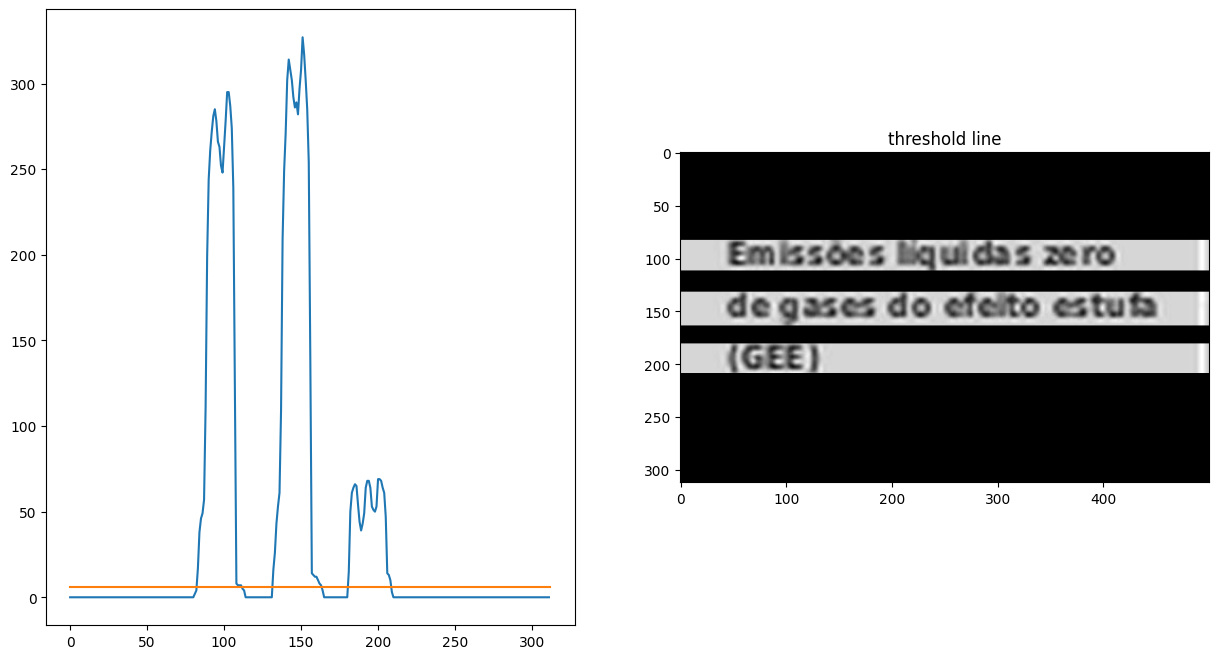

In [16]:
from skimage.filters import threshold_otsu
import numpy as np
from skimage.color import rgb2gray

img = cv2.imread("pgcImagemAumentada.jpg")

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(imggray):
    threshold = threshold_otsu(imggray)
    return imggray < threshold
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

if img.ndim > 2: # is this is a rgb/rgba image
    imggray = rgb2gray(img)

binarized_image = binarize_image(imggray)
hpp = horizontal_projections(binarized_image)

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
#threshold = (np.max(hpp)-np.min(hpp))/2
threshold = 6
peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(imggray)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, imggray.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()

In [ ]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers >1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)[1:]
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 4]
print("peak groups found", len(peak_groups))

resultados = []
reader = easyocr.Reader(['pt'])
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[(sub_image_index[0]-8):sub_image_index[8]]
    im_gray = cv2.cvtColor(sub_image, cv2.COLOR_BGR2GRAY)
    th, im_THRESH_OTSU = cv2.threshold(im_gray, 128, 192, cv2.THRESH_OTSU)
    resultados.append(pytesseract.image_to_string(im_THRESH_OTSU))
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()
print(resultados)



In [ ]:
resultados

In [ ]:
basewidth = 500
imgAntiga = Image.open("pgcSample2.jpg").convert("RGB")
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.LANCZOS)
img.save("pgcImagemAumentada.jpg")
reader = easyocr.Reader(['pt'])

In [ ]:
import pytesseract
img = cv2.imread("pgcSample2.jpg")
print("resultado :" + pytesseract.image_to_string(img))

In [ ]:
img = cv2.imread("pgcImagemAumentada.jpg")
print("resultado :" + pytesseract.image_to_string(img))

In [ ]:
img = Image.open("pgcSample.png").convert("RGB")
x = lerTexto(img)

In [ ]:
img = cv2.imread("pgcSample2.jpg")

In [ ]:
img[:2]

In [ ]:
img = Image.open("pgcSample.png").convert("RGB")
img.save("pgcImageLerTexto.jpg")
img = cv2.imread("pgcImageLerTexto.jpg")
basewidth = 500
if img.ndim > 2: # is this is a rgb/rgba image
    imggray = rgb2gray(img)
binarized_image = binarize_image(imggray)
hpp = horizontal_projections(binarized_image)

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
#threshold = (np.max(hpp)-np.min(hpp))/2
threshold = 6
peaks = find_peak_regions(hpp, threshold)
peaks_indexes = np.array(peaks)[:, 0].astype(int)
segmented_img = np.copy(imggray)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers >1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)[1:]
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 4]

resultados = []
reader = easyocr.Reader(['pt'])
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[1]]
    imgResize = Image.fromarray(sub_image, "RGB")
    print(imgResize.size[0], imgResize.size[1])
    wpercent = (basewidth/float(imgResize.size[0]))
    hsize = int((float(imgResize.size[1])*float(wpercent)))
    print((basewidth,hsize))
    sub = imgResize.resize((basewidth,hsize), Image.LANCZOS)
    resultados.append(pytesseract.image_to_string(sub))
resultados

In [ ]:
img = Image.open("pgcImage.png")
sub_image = img[sub_image_index[0]:sub_image_index[1]]

In [ ]:
sub_image.size

In [ ]:
img[:]

In [ ]:
resultados

In [21]:
import ironpdf

pdf = PdfDocument.FromFile("my-content.pdf")

# Extract all pages to a folder as image files
pdf.RasterizeToImageFiles("assets/images/*.png",DPI=96)


Attempting import of IronPdf 2024.2.1.2
Checking directory "/home/thales/.local"
Checking directory "/usr/local"
Checking directory "/home/thales/anaconda3/envs/pgc39/../../.."
Warning! Failed to install .NET 6.0. Consider manually installing .NET 6.0 from https://dotnet.microsoft.com/en-us/download/dotnet/6.0


Exception: Failed to locate IronPdf.Slim.dll at '/home/thales/anaconda3/envs/pgc39/../../../IronPdf.Slim'. Please see https://ironpdf.com/troubleshooting/quick-ironpdf-troubleshooting/ for more information